----------
**IBM Attrition Analysis and Prediction**
=====================================

***XGB : CV - Accuracy (5 folds) =  .891***

***Vincent Lugat***

*October 2018*

----------

![](http://image.noelshack.com/fichiers/2018/41/1/1539014632-1-bye.png)

source : http://thecontextofthings.com/2017/01/06/employee-attrition/

- <a href='#1'>1. Load libraries and read the data</a>  
    - <a href='#1.1'>1.1. Load libraries</a> 
    - <a href='#1.2'>1.2. Read the data</a> 
    - <a href='#1.3'>1.3. Missing values</a> 
    - <a href='#1.4'>1.4. Reassign target and drop useless features</a> 
- <a href='#2'>2. Exploratory Data Analysis (EDA)</a> 
    - <a href='#2.1'>2.1. Head and describe</a> 
    - <a href='#2.2'>2.2. Target distribution (number and %)</a> 
    - <a href='#2.3'>2.3. Features distribution and barplot (hue = Attrition)</a> 
    - <a href='#2.4'>2.4. Pie plot and barplot</a> 
- <a href='#3'>3. Feature engineering and selection</a>
    - <a href='#3.1'>3.1. New features (24) </a> 
    - <a href='#3.2'>3.2. Drop some features</a> 
    - <a href='#3.3'>3.3. Features encoding and scaling</a>
    - <a href='#3.4'>3.4. Correlation Matrix</a>
    - <a href='#3.5'>3.5. Remove collinear features</a>
- <a href='#4'>4. Define functions</a>
    - <a href='#4.1'>4.1. Define model performance plot </a> 
    - <a href='#4.2'>4.2. Define feature importance plot </a> 
    - <a href='#4.3'>4.3. Define cumulative gains curve</a>
    - <a href='#4.4'>4.4. Define cross validation metrics</a>
- <a href='#5'>5. Prepare dataset</a>
    - <a href='#5.1'>5.1. Define (X,  y)</a> 
    - <a href='#5.2'>5.2. Train test split</a> 
- <a href='#6'>6. XGBoost - RandomizedSearchCV to optimize hyperparameters (800 comb)</a> 

- <a href='#7'>7. XGBoost - With best hyperparameters = 89.11</a>
    - <a href='#7.1'>7.1. XGBoost - Modeling and performance plot</a> 
    - <a href='#7.2'>7.2. XGBoost - Feature importance </a> 
    - <a href='#7.3'>7.3. XGBoost - Cumulative gains curve</a> 
    - <a href='#7.4'>7.4. XGBoost - Cross validation (5 folds)</a> 

# <a id='1'>1. Load libraries and read the data</a> 

## <a id='1.1'>1.1. Load libraries</a> 

In [1]:
# Python libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
#import xgboost as xgb
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore')

## <a id='1.2'>1.2. Read the data</a>

In [2]:
data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

## <a id='1.3'>1.3. Missing values</a>

In [3]:
null_feat = pd.DataFrame(len(data['Attrition']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

## <a id='1.4'>1.4. Reassign target and drop useless features</a>

In [4]:
# Reassign target
data.Attrition.replace(to_replace = dict(Yes = 1, No = 0), inplace = True)
# Drop useless feat
data = data.drop(columns=['StandardHours', 
                          'EmployeeCount', 
                          'Over18',
                        ])

# <a id='2'>2. Exploratory Data Analysis (EDA)</a>

## <a id='2.1'>2.1. Head and describe</a> 

In [5]:
# head
data.head()

Age  Attrition     BusinessTravel  DailyRate              Department  \
0   41          1      Travel_Rarely       1102                   Sales   
1   49          0  Travel_Frequently        279  Research & Development   
2   37          1      Travel_Rarely       1373  Research & Development   
3   33          0  Travel_Frequently       1392  Research & Development   
4   27          0      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeNumber  \
0                 1          2  Life Sciences               1   
1                 8          1  Life Sciences               2   
2                 2          2          Other               4   
3                 3          4  Life Sciences               5   
4                 2          1        Medical               7   

   EnvironmentSatisfaction  ... PerformanceRating  RelationshipSatisfaction  \
0                        2  ...                 3                         1   
1                        3  ...                 4                         4   
2                        4  ...                 3                         2   
3                        4  ...                 3                         3   
4                        1  ...                 3                         4   

   StockOptionLevel  TotalWorkingYears TrainingTimesLastYear  WorkLifeBalance  \
0                 0                  8                     0                1   
1                 1                 10                     3                3   
2                 0                  7                     3                3   
3                 0                  8                     3                3   
4                 1                  6                     3                3   

  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
0              6                   4                        0   
1             10                   7                        1   
2              0                   0                        0   
3              8                   7                        3   
4              2                   2                        2   

   YearsWithCurrManager  
0                     5  
1                     7  
2                     0  
3                     0  
4                     2  

[5 rows x 32 columns]

In [6]:
# describe
data.describe()

Age    Attrition    DailyRate  DistanceFromHome    Education  \
count  1470.000000  1470.000000  1470.000000       1470.000000  1470.000000   
mean     36.923810     0.161224   802.485714          9.192517     2.912925   
std       9.135373     0.367863   403.509100          8.106864     1.024165   
min      18.000000     0.000000   102.000000          1.000000     1.000000   
25%      30.000000     0.000000   465.000000          2.000000     2.000000   
50%      36.000000     0.000000   802.000000          7.000000     3.000000   
75%      43.000000     0.000000  1157.000000         14.000000     4.000000   
max      60.000000     1.000000  1499.000000         29.000000     5.000000   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        602.024335                 1.093082    20.329428        0.711561   
min          1.000000                 1.000000    30.000000        1.000000   
25%        491.250000                 2.000000    48.000000        2.000000   
50%       1020.500000                 3.000000    66.000000        3.000000   
75%       1555.750000                 4.000000    83.750000        3.000000   
max       2068.000000                 4.000000   100.000000        4.000000   

          JobLevel  ...  PerformanceRating  RelationshipSatisfaction  \
count  1470.000000  ...        1470.000000               1470.000000   
mean      2.063946  ...           3.153741                  2.712245   
std       1.106940  ...           0.360824                  1.081209   
min       1.000000  ...           3.000000                  1.000000   
25%       1.000000  ...           3.000000                  2.000000   
50%       2.000000  ...           3.000000                  3.000000   
75%       3.000000  ...           3.000000                  4.000000   
max       5.000000  ...           4.000000                  4.000000   

       StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
count       1470.000000        1470.000000            1470.000000   
mean           0.793878          11.279592               2.799320   
std            0.852077           7.780782               1.289271   
min            0.000000           0.000000               0.000000   
25%            0.000000           6.000000               2.000000   
50%            1.000000          10.000000               3.000000   
75%            1.000000          15.000000               3.000000   
max            3.000000          40.000000               6.000000   

       WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
count      1470.000000     1470.000000         1470.000000   
mean          2.761224        7.008163            4.229252   
std           0.706476        6.126525            3.623137   
min           1.000000        0.000000            0.000000   
25%           2.000000        3.000000            2.000000   
50%           3.000000        5.000000            3.000000   
75%           3.000000        9.000000            7.000000   
max           4.000000       40.000000           18.000000   

       YearsSinceLastPromotion  YearsWithCurrManager  
count              1470.000000           1470.000000  
mean                  2.187755              4.123129  
std                   3.222430              3.568136  
min                   0.000000              0.000000  
25%                   0.000000              2.000000  
50%                   1.000000              3.000000  
75%                   3.000000              7.000000  
max                  15.000000             17.000000  

[8 rows x 25 columns]

## <a id='2.2'>2.2. Target distribution (number and %)</a> 

In [43]:
attrition = data[(data['Attrition'] != 0)]
no_attrition = data[(data['Attrition'] == 0)]

#------------COUNT-----------------------
trace = go.Bar(x = (len(attrition), len(no_attrition)), y = ['Yes_attrition', 'No_attrition'], orientation = 'h', opacity = 0.8, marker=dict(
        color=['gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of attrition variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

#------------PERCENTAGE-------------------
trace = go.Pie(labels = ['No_attrition', 'Yes_attrition'], values = data['Attrition'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of attrition variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [44]:
attrition

Age          ...           YearsWithCurrManager
0      41          ...                              5
2      37          ...                              0
14     28          ...                              3
21     36          ...                              3
24     34          ...                              3
26     32          ...                              7
33     39          ...                              0
34     24          ...                              0
36     50          ...                              2
42     26          ...                              1
45     41          ...                              8
50     48          ...                              0
51     28          ...                              2
69     36          ...                              0
89     46          ...                              7
100    37          ...                              2
102    20          ...                              0
107    25          ...                              3
111    34          ...                              6
122    56          ...                              3
124    31          ...                              7
126    58          ...                              6
127    19          ...                              0
132    31          ...                              2
136    51          ...                              3
140    32          ...                              4
171    19          ...                              0
177    19          ...                              0
182    41          ...                              2
192    35          ...                              1
...   ...          ...                            ...
1262   43          ...                              0
1271   21          ...                              0
1273   22          ...                              0
1279   44          ...                              3
1281   35          ...                              7
1290   34          ...                              7
1291   37          ...                              8
1297   26          ...                              4
1298   46          ...                              7
1312   31          ...                              0
1313   29          ...                              0
1326   32          ...                              2
1332   29          ...                              0
1333   46          ...                              7
1338   30          ...                              0
1339   22          ...                              0
1353   34          ...                              0
1354   56          ...                              0
1365   29          ...                              0
1369   28          ...                              2
1375   32          ...                              3
1379   27          ...                              0
1390   28          ...                              3
1395   31          ...                              8
1396   53          ...                              2
1438   23          ...                              0
1442   29          ...                              2
1444   56          ...                              8
1452   50          ...                              1
1461   50          ...                              0

[237 rows x 32 columns]

In [45]:
no_attrition

Age          ...           YearsWithCurrManager
1      49          ...                              7
3      33          ...                              0
4      27          ...                              2
5      32          ...                              6
6      59          ...                              0
7      30          ...                              0
8      38          ...                              8
9      36          ...                              7
10     35          ...                              3
11     29          ...                              8
12     31          ...                              3
13     34          ...                              2
15     29          ...                              8
16     32          ...                              5
17     22          ...                              0
18     53          ...                              7
19     38          ...                              2
20     24          ...                              3
22     34          ...                             11
23     21          ...                              0
25     53          ...                              8
27     42          ...                              2
28     44          ...                             17
29     46          ...                              1
30     33          ...                              0
31     44          ...                              3
32     30          ...                              8
35     43          ...                              4
37     35          ...                              2
38     36          ...                              0
...   ...          ...                            ...
1435   44          ...                              2
1436   21          ...                              2
1437   39          ...                              3
1439   36          ...                              4
1440   36          ...                              2
1441   56          ...                              9
1443   42          ...                             14
1445   41          ...                             10
1446   34          ...                              7
1447   36          ...                             11
1448   41          ...                              4
1449   32          ...                              2
1450   35          ...                              7
1451   38          ...                              9
1453   36          ...                              0
1454   45          ...                              1
1455   40          ...                              2
1456   35          ...                              2
1457   40          ...                              2
1458   35          ...                              1
1459   29          ...                              3
1460   29          ...                              4
1462   39          ...                              6
1463   31          ...                              7
1464   26          ...                              0
1465   36          ...                              3
1466   39          ...                              7
1467   27          ...                              3
1468   49          ...                              8
1469   34          ...                              2

[1233 rows x 32 columns]

## <a id='2.3'>2.3. Features distribution and barplot (hue = Attrition)</a> 

In [73]:
# Calculate the correlation coefficient between the new variable and the target
corr = data['Attrition'].corr(data['Age'])
corr = np.round(corr,3)
tmp1 = attrition['Age']
tmp2 = no_attrition['Age']
hist_data = [tmp1, tmp2]

In [74]:
corr

-0.159

In [75]:

print(tmp1)
print(tmp2)
# tmp1 will find Age with attrition and tmp2 will find age without attrition
# in both series of tmp1 and tmp2 below first column represent index and second column represent corresponding Age

0       41
2       37
14      28
21      36
24      34
26      32
33      39
34      24
36      50
42      26
45      41
50      48
51      28
69      36
89      46
100     37
102     20
107     25
111     34
122     56
124     31
126     58
127     19
132     31
136     51
140     32
171     19
177     19
182     41
192     35
        ..
1262    43
1271    21
1273    22
1279    44
1281    35
1290    34
1291    37
1297    26
1298    46
1312    31
1313    29
1326    32
1332    29
1333    46
1338    30
1339    22
1353    34
1354    56
1365    29
1369    28
1375    32
1379    27
1390    28
1395    31
1396    53
1438    23
1442    29
1444    56
1452    50
1461    50
Name: Age, Length: 237, dtype: int64
1       49
3       33
4       27
5       32
6       59
7       30
8       38
9       36
10      35
11      29
12      31
13      34
15      29
16      32
17      22
18      53
19      38
20      24
22      34
23      21
25      53
27      42
28      44
29      46
30      33
31      44
32    

In [76]:
hist_data

[0       41
 2       37
 14      28
 21      36
 24      34
 26      32
 33      39
 34      24
 36      50
 42      26
 45      41
 50      48
 51      28
 69      36
 89      46
 100     37
 102     20
 107     25
 111     34
 122     56
 124     31
 126     58
 127     19
 132     31
 136     51
 140     32
 171     19
 177     19
 182     41
 192     35
         ..
 1262    43
 1271    21
 1273    22
 1279    44
 1281    35
 1290    34
 1291    37
 1297    26
 1298    46
 1312    31
 1313    29
 1326    32
 1332    29
 1333    46
 1338    30
 1339    22
 1353    34
 1354    56
 1365    29
 1369    28
 1375    32
 1379    27
 1390    28
 1395    31
 1396    53
 1438    23
 1442    29
 1444    56
 1452    50
 1461    50
 Name: Age, Length: 237, dtype: int64, 1       49
 3       33
 4       27
 5       32
 6       59
 7       30
 8       38
 9       36
 10      35
 11      29
 12      31
 13      34
 15      29
 16      32
 17      22
 18      53
 19      38
 20      24
 22      34
 2

In [64]:
tmp1 = data[(data['Attrition'] != 0)]
tmp2 = data[(data['Attrition'] == 0)]
tmp3 = pd.DataFrame(pd.crosstab(data['Age'],data['Attrition']),)
tmp3['Attr%'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100
tmp3 = tmp3.sort_values(1, ascending = False)

x=tmp1['Age'].value_counts().keys().tolist(),
y=tmp1['Age'].value_counts().values.tolist(),

In [66]:
tmp3

Attrition   0   1      Attr%
Age                         
31         51  18  26.086957
29         50  18  26.470588
28         34  14  29.166667
26         27  12  30.769231
33         46  12  20.689655
32         50  11  18.032787
35         68  10  12.820513
30         51   9  15.000000
34         68   9  11.688312
24         19   7  26.923077
19          3   6  66.666667
37         44   6  12.000000
36         63   6   8.695652
39         36   6  14.285714
44         27   6  18.181818
25         20   6  23.076923
21          7   6  46.153846
20          5   6  54.545455
41         34   6  15.000000
50         25   5  16.666667
58          9   5  35.714286
22         11   5  31.250000
40         52   5   8.771930
46         29   4  12.121212
18          4   4  50.000000
23         10   4  28.571429
52         15   3  16.666667
56         11   3  21.428571
47         21   3  12.500000
55         19   3  13.636364
27         45   3   6.250000
42         44   2   4.347826
53         17   2  10.526316
43         30   2   6.250000
51         17   2  10.526316
49         22   2   8.333333
48         17   2  10.526316
38         56   2   3.448276
45         39   2   4.878049
54         18   0   0.000000
57          4   0   0.000000
59         10   0   0.000000
60          5   0   0.000000

In [71]:
x=tmp1['Age'].value_counts().keys().tolist(),
y=tmp1['Age'].value_counts().values.tolist(),

print(x)
print('\n')
print(y)

([29, 31, 28, 26, 33, 32, 35, 30, 34, 24, 25, 36, 44, 21, 20, 41, 19, 39, 37, 22, 58, 40, 50, 18, 23, 46, 27, 55, 52, 56, 47, 38, 49, 45, 51, 43, 53, 42, 48],)


([18, 18, 14, 12, 12, 11, 10, 9, 9, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2],)


In [46]:
def plot_distribution(var_select, bin_size) : 
# Calculate the correlation coefficient between the new variable and the target
    corr = data['Attrition'].corr(data[var_select])
    corr = np.round(corr,3)
    tmp1 = attrition[var_select]
    tmp2 = no_attrition[var_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Yes_attrition', 'No_attrition']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, curve_type='kde', bin_size = bin_size)
    
    fig['layout'].update(title = var_select+' '+'(corr target ='+ str(corr)+')')

    py.iplot(fig, filename = 'Density plot')

In [47]:
def barplot(var_select, x_no_numeric) :
    tmp1 = data[(data['Attrition'] != 0)]
    tmp2 = data[(data['Attrition'] == 0)]
    tmp3 = pd.DataFrame(pd.crosstab(data[var_select],data['Attrition']), )
    tmp3['Attr%'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100
    if x_no_numeric == True  : 
        tmp3 = tmp3.sort_values(1, ascending = False)

    color=['lightskyblue','gold' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        name='Yes_Attrition',opacity = 0.8, marker=dict(
        color='gold',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        name='No_Attrition', opacity = 0.8, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp3.index,
        y=tmp3['Attr%'],
        yaxis = 'y2',
        name='% Attrition', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% Attrition'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

In [80]:
plot_distribution('Age', False)
barplot('Age', False)
plot_distribution('DailyRate', 100)
plot_distribution('DistanceFromHome', False)
barplot('DistanceFromHome', False)
plot_distribution('HourlyRate', False)
plot_distribution('MonthlyIncome', 100)
plot_distribution('MonthlyRate', 100)
plot_distribution('NumCompaniesWorked', False)
barplot('NumCompaniesWorked',False)
plot_distribution('PercentSalaryHike', False)
barplot('PercentSalaryHike', False) 
plot_distribution('TotalWorkingYears', False)
barplot('TotalWorkingYears', False)
plot_distribution('TrainingTimesLastYear', False)
barplot('TrainingTimesLastYear',False)
plot_distribution('YearsAtCompany', False)
barplot('YearsAtCompany', False)
plot_distribution('YearsInCurrentRole', False)
barplot('YearsInCurrentRole', False)
plot_distribution('YearsSinceLastPromotion', False)
barplot('YearsSinceLastPromotion', False)
plot_distribution('YearsWithCurrManager', False)
barplot('YearsWithCurrManager', False)

## <a id='2.4'>2.4. Pie plot and barplot</a> 

In [77]:
def plot_pie(var_select) :
    
    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightgrey', 'orange', 'white', 'lightpink']
    trace1 = go.Pie(values  = attrition[var_select].value_counts().values.tolist(),
                    labels  = attrition[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "attrition employes",
                    marker  = dict(colors = colors, line = dict(width = 1.5)))
    trace2 = go.Pie(values  = no_attrition[var_select].value_counts().values.tolist(),
                    labels  = no_attrition[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hoverinfo = "label+percent+name",
                    marker  = dict(colors = colors, line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Non attrition employes" )

    layout = go.Layout(dict(title = var_select + " distribution in employes attrition ",
                            annotations = [dict(text = "Yes_attrition",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                            dict(text = "No_attrition",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)]))
                                          

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    py.iplot(fig)

In [78]:
plot_pie("Gender")
barplot('Gender',True)
plot_pie('OverTime')
barplot('OverTime',True)
plot_pie('BusinessTravel')
barplot('BusinessTravel',True)
plot_pie('JobRole')
barplot('JobRole',True)
plot_pie('Department') 
barplot('Department',True)
plot_pie('MaritalStatus') 
barplot('MaritalStatus',True)
plot_pie('EducationField') 
barplot('EducationField',True)
plot_pie('Education') 
barplot('Education',False)
plot_pie('EnvironmentSatisfaction')
barplot('EnvironmentSatisfaction',False)
plot_pie('JobInvolvement')
barplot('JobInvolvement', False)
plot_pie('JobLevel')
barplot('JobLevel',False)
plot_pie('JobSatisfaction')
barplot('JobSatisfaction',False)
plot_pie('PerformanceRating')
barplot('PerformanceRating',False)
plot_pie('RelationshipSatisfaction')
barplot('RelationshipSatisfaction', False)
plot_pie('StockOptionLevel')
barplot('StockOptionLevel', False)
plot_pie('WorkLifeBalance')
barplot('WorkLifeBalance', False)

# <a id='3'>3. Feature engineering and selection</a>

## <a id='3.1'>3.1. New features : 24</a> 

In [81]:
def SalesDpt(data) :
    if data['Department'] == 'Sales':
        return 1
    else:
        return 0
data['SalesDpt'] = data.apply(lambda data:SalesDpt(data) ,axis = 1)

def JobInvCut(data) :
    if data['JobInvolvement'] < 2.5 :
        return 1
    else:
        return 0
data['JobInvCut'] = data.apply(lambda data:JobInvCut(data) ,axis = 1)

def MiddleTraining(data) :
    if data['TrainingTimesLastYear'] >= 3 and data['TrainingTimesLastYear'] <= 6:
        return 1
    else:
        return 0
data['MiddleTraining'] = data.apply(lambda data:MiddleTraining(data) ,axis = 1)

def MoovingPeople(data) :
    if data['NumCompaniesWorked'] > 4:
        return 1
    else:
        return 0
data['MoovingPeople'] = data.apply(lambda data:MoovingPeople(data), axis = 1)

data['TotalSatisfaction_mean'] = (data['RelationshipSatisfaction']  + data['EnvironmentSatisfaction'] + data['JobSatisfaction'] + data['JobInvolvement'] + data['WorkLifeBalance'])/5

def NotSatif(data) : 
    if  data['TotalSatisfaction_mean'] < 2.35 :
        return 1
    else : 
        return 0
data['NotSatif'] = data.apply(lambda data:NotSatif(data) ,axis = 1)

def LongDisWL1(data) : 
    if  data['DistanceFromHome'] > 11 and data['WorkLifeBalance'] == 1 :
        return 1
    else : 
        return 0
data['LongDisWL1'] = data.apply(lambda data:LongDisWL1(data) ,axis = 1)

def LongDis(data) : 
    if  data['DistanceFromHome'] > 11:
        return 1
    else : 
        return 0
data['LongDis'] = data.apply(lambda data:LongDis(data) ,axis = 1)

def LongDisJobS1(data) : 
    if  data['DistanceFromHome'] > 11 and data['JobSatisfaction'] == 1 :
        return 1
    else : 
        return 0
data['LongDisJobS1'] = data.apply(lambda data:LongDisJobS1(data) ,axis = 1)

def LongDisJL1(data) : 
    if  data['DistanceFromHome'] > 11 and data['JobLevel'] == 1 :
        return 1
    else : 
        return 0
data['LongDisJL1'] = data.apply(lambda data:LongDisJL1(data) ,axis = 1)

def ShortDisNotSingle(data) : 
    if  data['MaritalStatus'] != 'Single' and data['DistanceFromHome'] < 5:
        return 1
    else : 
        return 0
data['ShortDisNotSingle'] = data.apply(lambda data:ShortDisNotSingle(data) ,axis = 1)

def LongDisSingle(data) : 
    if  data['MaritalStatus'] == 'Single' and data['DistanceFromHome'] > 11:
        return 1
    else : 
        return 0
data['LongDisSingle'] = data.apply(lambda data:LongDisSingle(data) ,axis = 1)

def Engaged(data) : 
    if data['Age'] > 35 and data['MaritalStatus'] != 'Single':
        return 1
    else : 
        return 0
data['Engaged'] = data.apply(lambda data:Engaged(data) ,axis = 1)

def YoungAndBadPaid(data) : 
    if data['Age'] < 35 and data['Age'] > 23 and (data['MonthlyIncome'] < 3500):
        return 1
    else : 
        return 0
data['YoungAndBadPaid'] = data.apply(lambda data:YoungAndBadPaid(data) ,axis = 1)

def YoungNeverEngaged(data) : 
    if data['Age'] < 24 and data['MaritalStatus'] == 'Single' :
        return 1
    else : 
        return 0
data['YoungNeverEngaged'] = data.apply(lambda data:YoungNeverEngaged(data) ,axis = 1)

data['Time_in_each_comp'] = (data['Age'] - 20) / ((data)['NumCompaniesWorked'] + 1)
data['RelSatisf_mean'] = (data['RelationshipSatisfaction']  + data['EnvironmentSatisfaction']) / 2
data['JobSatisf_mean'] = (data['JobSatisfaction'] + data['JobInvolvement']) / 2
data['Income_Distance'] = data['MonthlyIncome'] / data['DistanceFromHome']
data['Hrate_Mrate'] = data['HourlyRate'] / data['MonthlyRate']
data['Stability'] = data['YearsInCurrentRole'] / data['YearsAtCompany']
data['Stability'].fillna((data['Stability'].mean()), inplace=True)
data['Income_YearsComp'] = data['MonthlyIncome'] / data['YearsAtCompany']
data['Income_YearsComp'] = data['Income_YearsComp'].replace(np.Inf, 0)
data['Fidelity'] = (data['NumCompaniesWorked']) / data['TotalWorkingYears']
data['Fidelity'] = data['Fidelity'].replace(np.Inf, 0)

In [82]:
barplot('Engaged', False)
barplot('YoungAndBadPaid', False)
barplot('YoungNeverEngaged', False)
barplot('LongDisSingle', False)
barplot('LongDisJL1', False)
barplot('ShortDisNotSingle', False)

In [83]:
data.head()

Age  Attrition    ...    Income_YearsComp  Fidelity
0   41          1    ...          998.833333  1.000000
1   49          0    ...          513.000000  0.100000
2   37          1    ...            0.000000  0.857143
3   33          0    ...          363.625000  0.125000
4   27          0    ...         1734.000000  1.500000

[5 rows x 55 columns]

In [84]:
data.shape

(1470, 55)

## <a id='3.2'>3.2. Drop some features</a> 

In [85]:
data = data.drop(columns=[
                        'Age',
                        'MonthlyIncome',
                        'YearsAtCompany',
                        'DistanceFromHome',
                        'PerformanceRating',
                        'NumCompaniesWorked'
                     ])

print ("\nMissing values :  ", data.isnull().sum().values.sum())


Missing values :   0


In [86]:
data.shape

(1470, 49)

## <a id='3.3'>3.3. Features encoding and scaling</a> 

In [87]:
#customer id col
Id_col     = ['EmployeeNumber']
#Target columns
target_col = ["Attrition"]
#categorical columns
cat_cols   = data.nunique()[data.nunique() < 10].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")
data = data.drop(['EmployeeNumber'],axis = 1)

In [88]:
data.head()

Attrition  Gender    ...     Income_YearsComp  Fidelity
0          1       0    ...            -0.241733  1.775509
1          0       1    ...            -0.473382 -0.620450
2          1       1    ...            -0.717985  1.395198
3          0       0    ...            -0.544605 -0.553896
4          0       1    ...             0.108800  3.106597

[5 rows x 111 columns]

## <a id='3.4'>3.4. Correlation Matrix</a> 

In [89]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale='Viridis',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        #height  = 1400,
                        #width   = 1600,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

## <a id='3.5'>3.5. Remove collinear features</a>

In [90]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = data.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove :' % (len(to_drop)))

data = data.drop(columns = to_drop)

to_drop

There are 7 columns to remove :


['Department_Research & Development',
 'Department_Sales',
 'JobInvolvement_2',
 'JobInvolvement_3',
 'JobRole_Human Resources',
 'JobRole_Sales Executive',
 'TrainingTimesLastYear_2']

In [91]:
data.shape

(1470, 104)

# <a id='4'>4. Define functions</a>

## <a id='4.1'>4.1. Define model performance plot</a> 

In [23]:
def model_performance_plot(model) : 
    #conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #plot roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : ",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                        subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance</b><br>'+str(model),
                        autosize = False, height = 900,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

## <a id='4.2'>4.2. Define feature importance plot</a> 

In [92]:
def features_imp(model, cf) : 

    coefficients  = pd.DataFrame(model.feature_importances_)
    column_data     = pd.DataFrame(list(data))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))
    layout = dict(title =  'Feature Importances xgb_cfl')
                    
    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

## <a id='4.3'>4.3. Define cumulative gains curve</a> 

In [93]:
#cumulative gain curve
def cum_gains_curve(model):
    pos = pd.get_dummies(y_test).as_matrix()
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = 'xgb_cfl'
    trace1 = go.Scatter(x = size,y = recall,
                        name = "Lift curve",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace2 = go.Scatter(x = size,y = size,
                        name = "Baseline",
                        showlegend=False,
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))

    layout = dict(title = 'Cumulative gains curve'+' '+str(model),
                  yaxis = dict(title = 'Percentage positive targeted',zeroline = False),
                  xaxis = dict(title = 'Percentage contacted', zeroline = False)
                 )

    fig  = go.Figure(data = [trace1,trace2], layout = layout)
    py.iplot(fig)

## <a id='4.4'>4.4. Define cross validation metrics</a> 

In [94]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

# <a id='5'>5. Prepare dataset</a>

## <a id='5.1'>5.1. Define (X, y)</a> 

In [95]:
# Def X and Y
y = np.array(data.Attrition.tolist())
data = data.drop('Attrition', 1)
X = np.array(data.as_matrix())

## <a id='5.2'>5.2. Train test split</a> 

In [96]:
# Train_test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)

In [ ]:
X_train.shape, X_test.shape

# <a id='6'>6. XGBoost - RandomizedSearchCV to optimize hyperparameters</a>

In [29]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)


# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 750],
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5
param_comb = 800

random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
#----------------------------# random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 0.0 seconds.


Remove "#----------------------------#" to lunch random_search

In [30]:
#print('\n All results:')
#print(random_search.cv_results_)
#print('\n Best estimator:')
#print(random_search.best_estimator_)
#print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
#print(random_search.best_score_ )
#print('\n Best hyperparameters:')
#print(random_search.best_params_)
#results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)



**RESULT : **

Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1.5, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
       n_estimators=200, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6)

 Best accuracy for 5-fold search with 800 parameter combinations:
0.891156462585034

 Best hyperparameters:
{'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 1.5, 'colsample_bytree': 0.8}

# <a id='7'>7. XGBoost - Modeling with best hyperparameters = 89.11</a>

## <a id='7.1'>7.1. XGBoost - Modeling and performance plot</a> 

In [31]:
# xgb 
xgb_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                           colsample_bytree=0.8, gamma=1.5, learning_rate=0.05,
                           max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
                           n_estimators=200, n_jobs=-1, nthread=None,
                           objective='binary:logistic', random_state=0, reg_alpha=0,
                           reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                           subsample=0.6)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_score = xgb_clf.predict_proba(X_test)[:,1]

model_performance_plot('xgb_clf')

## <a id='7.2'>7.2. XGBoost - Feature importance </a>

In [32]:
features_imp(xgb_clf, 'features')

In [33]:
#feature importance plot TOP 40
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
def plot_feature_importance(model):
    tmp = pd.DataFrame({'Feature': list(data), 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(30)
    plt.figure(figsize = (10,12))
    plt.title('Top 30 - Features importance - XGBoost',fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h')
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

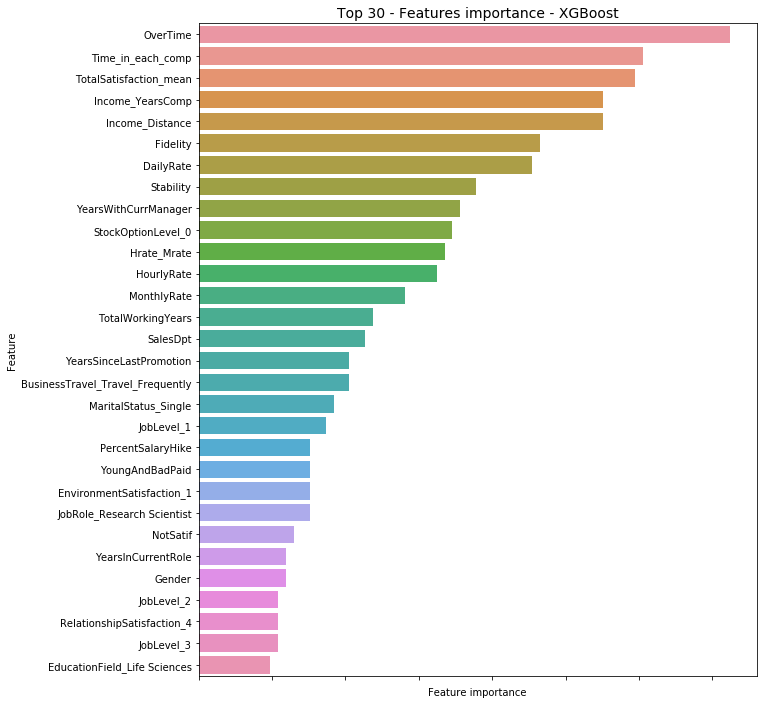

In [34]:
plot_feature_importance(xgb_clf)

## <a id='7.3'>7.3. XGBoost - Cumulative gain curve</a> 

In [35]:
cum_gains_curve(xgb_clf)

## <a id='7.4'>7.4. XGBoost - Cross validation (5 folds)</a> 

In [36]:
# Cross val score
cross_val_metrics(xgb_clf)

[accuracy] : 0.89115 (+/- 0.00621)
[precision] : 0.82588 (+/- 0.04748)
[recall] : 0.41348 (+/- 0.03070)


**Thank you all ! Merci à tous ! :)**